In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # train_df processing, CSV file I/O (e.g. pd.read_csv)

# Input train_df files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/delhiclimate/DailyDelhiClimateTrain.csv
/kaggle/input/delhitest/DailyDelhiClimateTest.csv


importing libraries which we need

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


reading datasets

In [26]:
train_df = pd.read_csv('/kaggle/input/delhiclimate/DailyDelhiClimateTrain.csv')
test_df = pd.read_csv('/kaggle/input/delhitest/DailyDelhiClimateTest.csv')


checking if there is any missing values in the dataset

In [27]:
print(train_df.head())

print(train_df.isnull().sum())

         date   meantemp   humidity  wind_speed  meanpressure
0  2013-01-01  10.000000  84.500000    0.000000   1015.666667
1  2013-01-02   7.400000  92.000000    2.980000   1017.800000
2  2013-01-03   7.166667  87.000000    4.633333   1018.666667
3  2013-01-04   8.666667  71.333333    1.233333   1017.166667
4  2013-01-05   6.000000  86.833333    3.700000   1016.500000
date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64


visualizing features's distribution, we can see they are close to normal distribution so we use standardscalar

          meantemp     humidity   wind_speed  meanpressure
count  1462.000000  1462.000000  1462.000000   1462.000000
mean     25.495521    60.771702     6.802209   1011.104548
std       7.348103    16.769652     4.561602    180.231668
min       6.000000    13.428571     0.000000     -3.041667
25%      18.857143    50.375000     3.475000   1001.580357
50%      27.714286    62.625000     6.221667   1008.563492
75%      31.305804    72.218750     9.238235   1014.944901
max      38.714286   100.000000    42.220000   7679.333333


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


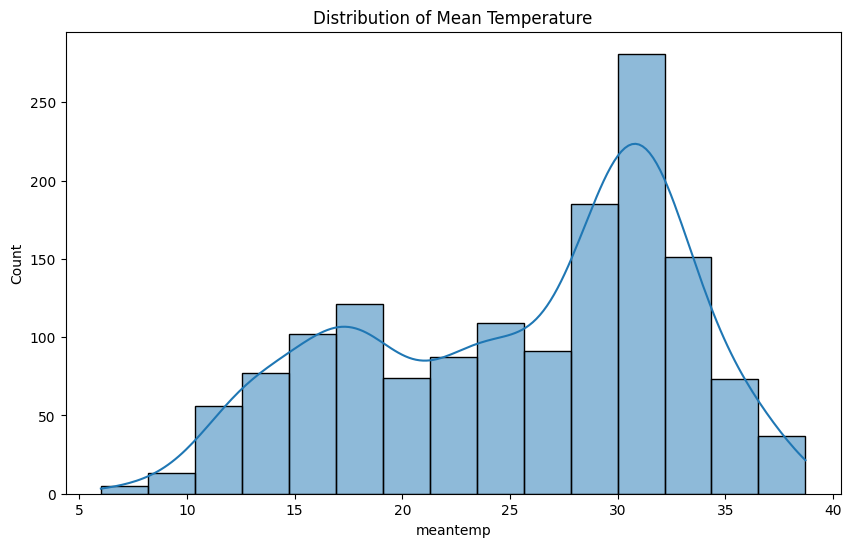

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


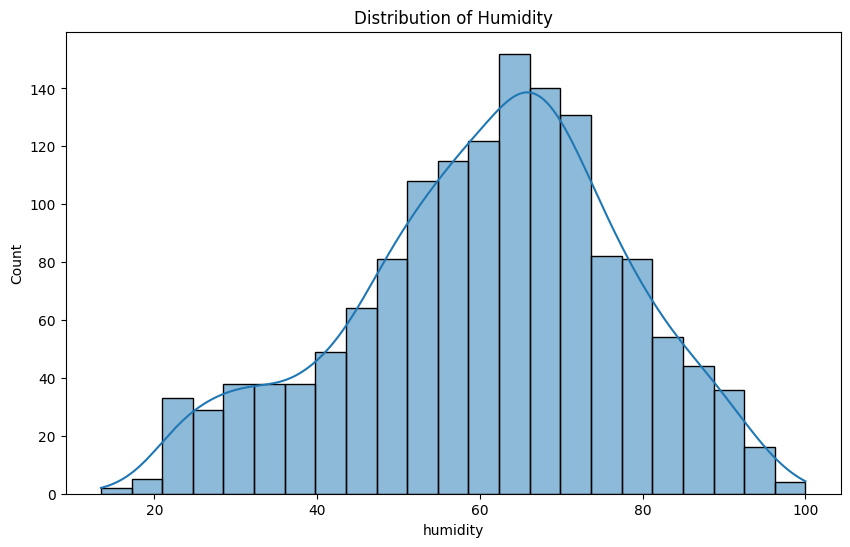

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


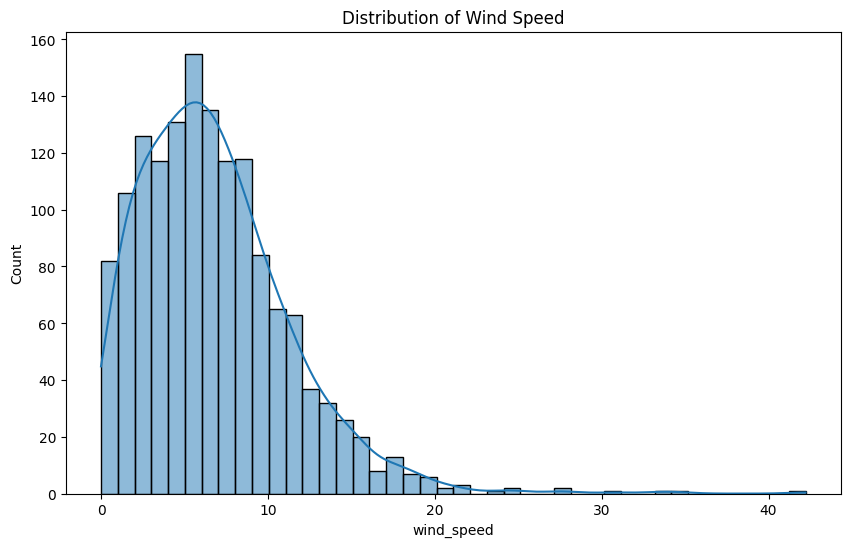

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


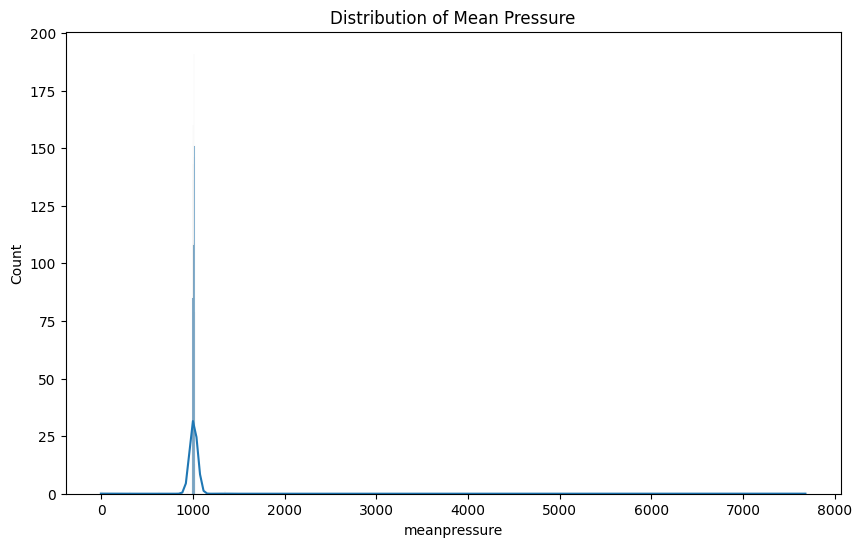

In [28]:

#summary statistics
print(train_df.describe())

#visualize distributions
plt.figure(figsize=(10, 6))
sns.histplot(train_df['meantemp'], kde=True)
plt.title('Distribution of Mean Temperature')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(train_df['humidity'], kde=True)
plt.title('Distribution of Humidity')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(train_df['wind_speed'], kde=True)
plt.title('Distribution of Wind Speed')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(train_df['meanpressure'], kde=True)
plt.title('Distribution of Mean Pressure')
plt.show()


feature engineering part
 - added some new features which i didn't use them because results wouldn't improve
 - normalization, or transformation to ensure the features are in a suitable range

In [29]:
from sklearn.preprocessing import StandardScaler
#train dataset
#convert 'date' column to datetime
train_df['date'] = pd.to_datetime(train_df['date'])

#define some new features which they weren't good(feature engineering)
train_df['temp_humidity_interaction'] = train_df['meantemp'] * train_df['humidity']
train_df['wind_pressure_interaction'] = train_df['wind_speed'] * train_df['meanpressure']
train_df['month'] = train_df['date'].dt.month
train_df['rolling_mean_7_meanpressure'] = train_df['meanpressure'].rolling(window=7).mean()

train_df = train_df.dropna()

#select features and target variable
features_to_normalize = [
    'humidity', 'meantemp', 'wind_speed'  , 'temp_humidity_interaction' 
    , 'wind_pressure_interaction'
]

#initialize the StandardScaler
scaler = StandardScaler()

#fit and transform the features
train_df[features_to_normalize] = scaler.fit_transform(train_df[features_to_normalize])

#display the first few rows of the modified train_dfFrame
print(train_df.head())


         date  meantemp  humidity  wind_speed  meanpressure  \
6  2013-01-07 -2.553913  1.071620   -0.114186   1020.000000   
7  2013-01-08 -2.298486  0.181666    0.070680   1018.714286   
8  2013-01-09 -1.591150 -0.563520    1.245681   1017.000000   
9  2013-01-10 -2.003763  0.079177    0.127080   1015.666667   
10 2013-01-11 -1.355371 -0.561385    0.822681   1016.142857   

    temp_humidity_interaction  wind_pressure_interaction  month  \
6                   -2.018635                  -0.095830      1   
7                   -1.988045                   0.084004      1   
8                   -1.656360                   1.233375      1   
9                   -1.733233                   0.134623      1   
10                  -1.464897                   0.816753      1   

    rolling_mean_7_meanpressure  
6                   1017.685714  
7                   1018.121088  
8                   1018.006803  
9                   1017.578231  
10                  1017.431973  


In [30]:
#test dataset
#convert 'date' column to datetime
test_df['date'] = pd.to_datetime(test_df['date'])


#define some new features which they weren't good
test_df['rolling_mean_7_meanpressure'] = test_df['meanpressure'].rolling(window=7).mean()
test_df['temp_humidity_interaction'] = test_df['meantemp'] * test_df['humidity']
test_df['wind_pressure_interaction'] = test_df['wind_speed'] * test_df['meanpressure']
test_df.loc[:, 'month'] = test_df['date'].dt.month
test_df = test_df.dropna()
#transform the test dataset
test_df[features_to_normalize] = scaler.transform(test_df[features_to_normalize])

print(test_df.head())


         date  meantemp  humidity  wind_speed  meanpressure  \
6  2017-01-07 -1.493727  2.101927    0.706486   1011.375000   
7  2017-01-08 -1.359507  1.366143   -1.068287   1015.550000   
8  2017-01-09 -1.512557  1.203718   -0.060920   1015.952381   
9  2017-01-10 -1.850943  0.673713    0.557218   1016.888889   
10 2017-01-11 -2.003763  0.683677    0.647388   1016.777778   

    rolling_mean_7_meanpressure  temp_humidity_interaction  \
6                    878.398882                  -0.157784   
7                   1015.048882                  -0.373252   
8                   1014.716682                  -0.660244   
9                   1014.510333                  -1.323260   
10                  1014.664301                  -1.492390   

    wind_pressure_interaction  month  
6                    0.692810      1  
7                   -1.035815      1  
8                   -0.049053      1  
9                    0.558192      1  
10                   0.646355      1  


In [31]:
#setting up
X_train = train_df[[
       'meantemp', 'humidity', 'wind_speed'  
]
]
y_train = train_df['meanpressure']
X_test = test_df[[
       'meantemp', 'humidity', 'wind_speed'
]
]
y_test = test_df['meanpressure']
print(X_test.head())

    meantemp  humidity  wind_speed
6  -1.493727  2.101927    0.706486
7  -1.359507  1.366143   -1.068287
8  -1.512557  1.203718   -0.060920
9  -1.850943  0.673713    0.557218
10 -2.003763  0.683677    0.647388


Hyperparameters tunning part
we use LSTM to find the best optimizer and loss function ,
we use the same setting for RNN and GRU so we can compare them equally on the same setting

In [32]:
#reshape train_df for LSTM model
import keras_tuner as kt
import tensorflow as tf

X_train_reshaped = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
def build_model(hp):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    
    #Hyperparameters to tune
    hp_optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
    hp_loss = hp.Choice('loss', values=['mean_squared_error', 'mean_absolute_error'])
    
    model.compile(optimizer=hp_optimizer, loss=hp_loss)
    return model

#tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    overwrite=True  # This ensures that no state is saved
)

#define early stopping callback
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

#search for the best hyperparameters
tuner.search(X_train_reshaped, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

#get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]




Trial 6 Complete [00h 00m 04s]
val_loss: 1015.0403442382812

Best val_loss So Far: 969.0414428710938
Total elapsed time: 00h 00m 29s


In [33]:
print(best_hps.get('optimizer'))
print(best_hps.get('loss'))

rmsprop
mean_absolute_error


initialize and train LSTM

In [34]:
#Fit the Final model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer= best_hps.get('optimizer'), loss=best_hps.get('loss'))

# Train the model
model.fit(X_train_reshaped, y_train, batch_size=20, epochs=50)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1002.2570
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 938.1245
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 879.9674
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 805.8384
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 720.5656
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 642.5228
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 520.2911
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 383.6748
Epoch 9/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 248.1686
Epoch 10/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 89.0488
Epoch 11/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11.0685
Epoch 12/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11.4003
Epoch 13/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 20.8123
Epoch 14/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15.8559
Epoch 15/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12.8346
Epoch

In [35]:

X_test_reshaped = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))
y_pred_lstm = model.predict(X_test_reshaped)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step


RESULTS:

In [36]:
#Make predictions
Lstm_mae = mean_absolute_error(y_test, y_pred_lstm)
Lstm_mse = mean_squared_error(y_test, y_pred_lstm)
Lstm_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
Lstm_r2 = r2_score(y_test, y_pred_lstm)

print(f"LSTM Mean Absolute Error: {Lstm_mae}")
print(f"LSTM Mean Squared Error: {Lstm_mse}")
print(f"LSTM Root Mean Squared Error: {Lstm_rmse}")
print(f"LSTM R-squared: {Lstm_r2}")


LSTM Mean Absolute Error: 2.4268221682062867
LSTM Mean Squared Error: 9.26930104621187
LSTM Root Mean Squared Error: 3.0445526840920114
LSTM R-squared: 0.7191360747488955


initialize and train GRU

In [37]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

# Assuming X_train and y_train are your training data and labels
# X_train.shape = (num_samples, time_steps, num_features)
# y_train.shape = (num_samples, 1)

model_gru = Sequential()
model_gru.add(GRU(units=50, return_sequences=True ,input_shape=(X_train.shape[1], 1)))
model_gru.add(GRU(units=50 , return_sequences=False))
model_gru.add(Dense(25))
model_gru.add(Dense(1))

model_gru.compile(optimizer= best_hps.get('optimizer'), loss=best_hps.get('loss'))

model_gru.fit(X_train, y_train, epochs=50, batch_size=20)

# Evaluate the model
loss_gru = model_gru.evaluate(X_test, y_test)
print(f'GRU Test Loss: {loss_gru}')


Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1002.7692
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 937.5657
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 881.4595
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 817.9467
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 731.5283
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 636.0807
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 520.0826
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 394.0645
Epoch 9/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 270.4951
Epoch 10/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 105.0644
Epoch 11/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16.5329
Epoch 12/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 21.5012
Epoch 13/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15.5982
Epoch 14/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10.9366
Epoch 15/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 12.9347
Epoc

RESULTS:

In [38]:
y_pred_gru = model_gru.predict(X_test)
# Compute metrics
mae_gru = mean_absolute_error(y_test, y_pred_gru)
mse_gru = mean_squared_error(y_test, y_pred_gru)
rmse_gru = np.sqrt(mse_gru)
r2_gru = r2_score(y_test, y_pred_gru)

print(f'GRU Metrics:')
print(f'Mean Absolute Error: {mae_gru:.2f}')
print(f'Mean Squared Error: {mse_gru:.2f}')
print(f'Root Mean Squared Error: {rmse_gru:.2f}')
print(f'R-squared: {r2_gru:.2f}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step
GRU Metrics:
Mean Absolute Error: 2.23
Mean Squared Error: 8.83
Root Mean Squared Error: 2.97
R-squared: 0.73


initialize and train RNN

In [39]:
from tensorflow.keras.layers import SimpleRNN

model_rnn = Sequential()
model_rnn.add(SimpleRNN(units=50,return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_rnn.add(SimpleRNN(units=50 , return_sequences=False))
model_rnn.add(Dense(25))
model_rnn.add(Dense(1))

model_rnn.compile(optimizer= best_hps.get('optimizer'), loss=best_hps.get('loss'))

model_rnn.fit(X_train, y_train, epochs=50, batch_size=20)

# Evaluate the model
loss_rnn = model_rnn.evaluate(X_test, y_test)
print(f'RNN Test Loss: {loss_rnn}')


Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 996.8131
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 954.0613
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 910.8953
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 841.0585
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 772.2776
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 663.9527
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 562.5620
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 439.7437
Epoch 9/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 304.0432
Epoch 10/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 154.0255
Epoch 11/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17.9365
Epoch 12/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14.8595
Epoch 13/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.0439
Epoch 14/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17.2049
Epoch 15/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.6036
Epoch 

RESULTS:

In [40]:
# Predictions
y_pred_rnn = model_rnn.predict(X_test)

# Compute metrics
mae_rnn = mean_absolute_error(y_test, y_pred_rnn)
mse_rnn = mean_squared_error(y_test, y_pred_rnn)
rmse_rnn = np.sqrt(mse_rnn)
r2_rnn = r2_score(y_test, y_pred_rnn)

print(f'RNN Metrics:')
print(f'Mean Absolute Error: {mae_rnn:.2f}')
print(f'Mean Squared Error: {mse_rnn:.2f}')
print(f'Root Mean Squared Error: {rmse_rnn:.2f}')
print(f'R-squared: {r2_rnn:.2f}')


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
RNN Metrics:
Mean Absolute Error: 2.58
Mean Squared Error: 10.25
Root Mean Squared Error: 3.20
R-squared: 0.69


comparing models visually:

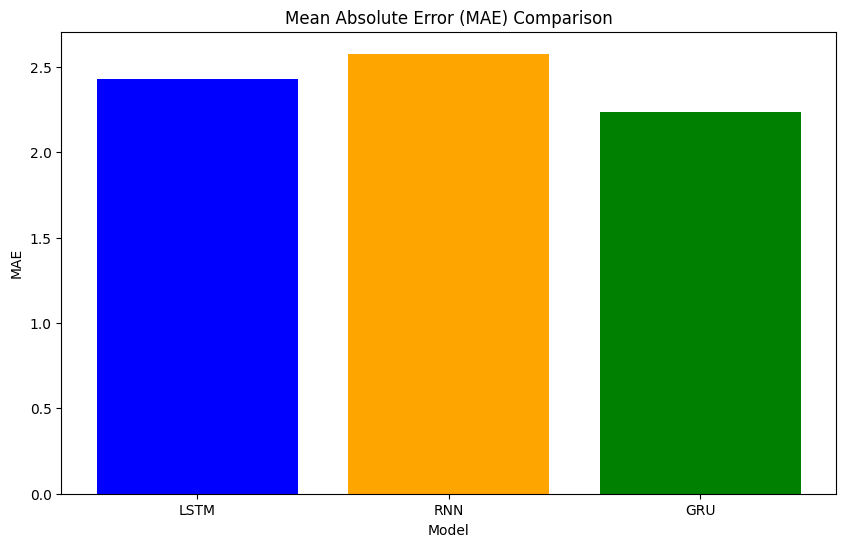

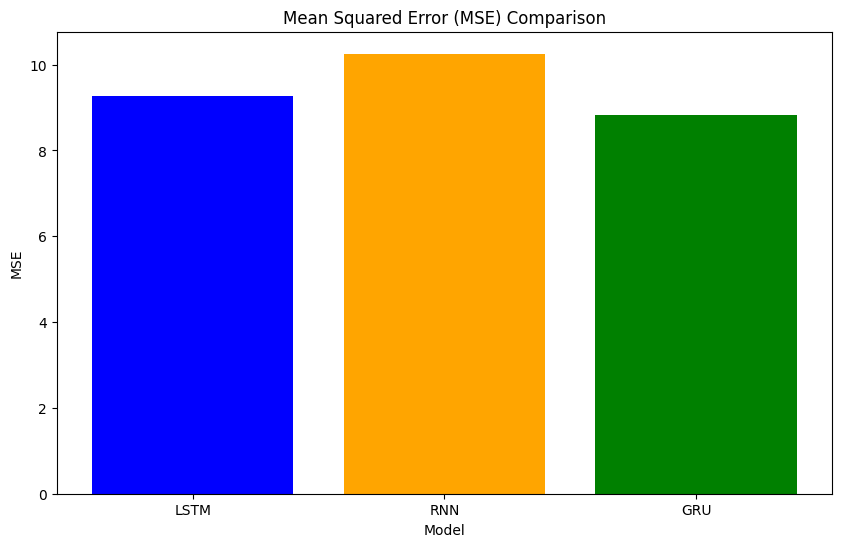

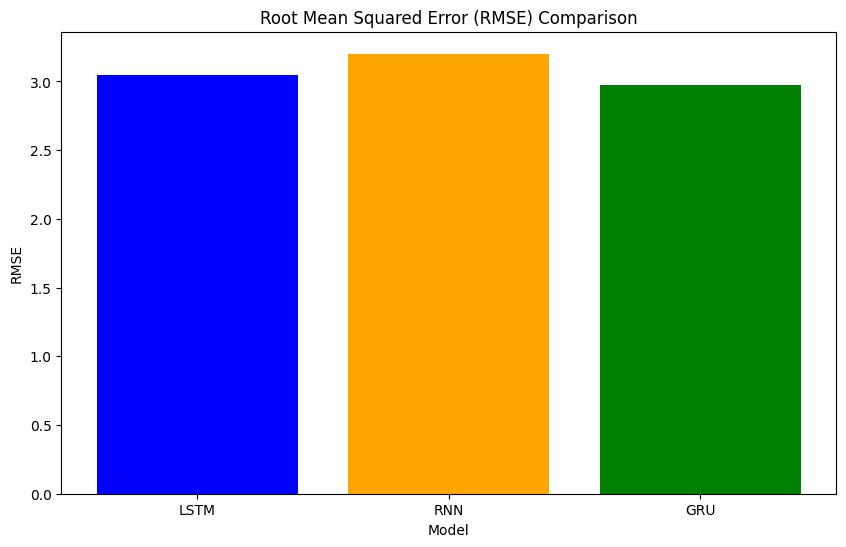

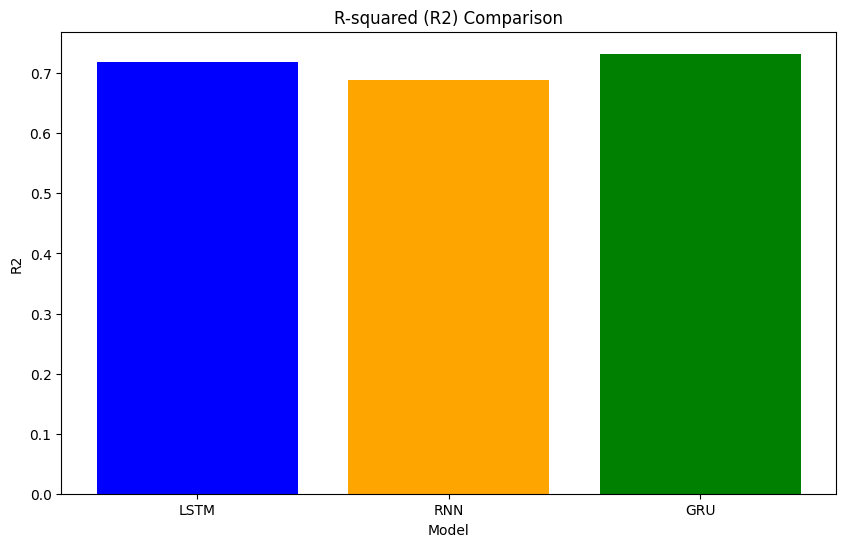

In [41]:
import matplotlib.pyplot as plt
import numpy as np

metrics = {
    "Model": ["LSTM", "RNN", "GRU"],
    "MAE": [Lstm_mae, mae_rnn, mae_gru],
    "MSE": [Lstm_mse, mse_rnn, mse_gru],
    "RMSE": [Lstm_rmse, rmse_rnn, rmse_gru],
    "R2": [Lstm_r2, r2_rnn, r2_gru]
}

#plot for MAE
plt.figure(figsize=(10, 6))
plt.bar(metrics["Model"], metrics["MAE"], color=['blue', 'orange', 'green'])
plt.title('Mean Absolute Error (MAE) Comparison')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.show()

#plot for MSE
plt.figure(figsize=(10, 6))
plt.bar(metrics["Model"], metrics["MSE"], color=['blue', 'orange', 'green'])
plt.title('Mean Squared Error (MSE) Comparison')
plt.xlabel('Model')
plt.ylabel('MSE')
plt.show()

#plot for RMSE
plt.figure(figsize=(10, 6))
plt.bar(metrics["Model"], metrics["RMSE"], color=['blue', 'orange', 'green'])
plt.title('Root Mean Squared Error (RMSE) Comparison')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.show()

#plot for R-squared
plt.figure(figsize=(10, 6))
plt.bar(metrics["Model"], metrics["R2"], color=['blue', 'orange', 'green'])
plt.title('R-squared (R2) Comparison')
plt.xlabel('Model')
plt.ylabel('R2')
plt.show()
